In [ ]:
import sqlite3
import matplotlib.pyplot as plt

# 常量
c = 3e8  # 光速，单位：m/s
lambda_532 = 532e-9  # m
lambda_800 = 800e-9  # m

# 角频率（rad/s）
omega_532 = 2 * 3.141592653589793 * c / lambda_532
omega_800 = 2 * 3.141592653589793 * c / lambda_800
delta_omega = omega_800 - omega_532  # 用于近似色散公式

# 连接数据库
conn = sqlite3.connect('D:/WORK/Achromatic_metalens_design_in_Windows/data/Main.db')  # 替换为你的数据库文件名
cursor = conn.cursor()

# 读取数据（假设表名为 'nanostructures'，请根据实际修改）
cursor.execute("SELECT angleIn532, angleIn800 FROM Parameter")
rows = cursor.fetchall()

# 存储数据
phi_532_list = []
delta_phi_list = []

for row in rows:
    phi_532, phi_800 = row

    # 基本检查防止空值
    if phi_532 is None or phi_800 is None:
        continue

    delta_phi = phi_800 - phi_532

    phi_532_list.append(phi_532)
    delta_phi_list.append(delta_phi)

# 关闭连接
conn.close()


In [ ]:
# 绘图
plt.figure(figsize=(8, 6))
plt.scatter(phi_532_list, delta_phi_list, c='blue', alpha=0.7, s=20)
plt.xlabel("Phase at 532 nm (rad)")
plt.ylabel("Phase difference (Δφ = φ800 - φ532) (rad)")
plt.title("Phase-Dispersion Space (based on 532–800 nm)")
plt.grid(True)
plt.tight_layout()
plt.show()

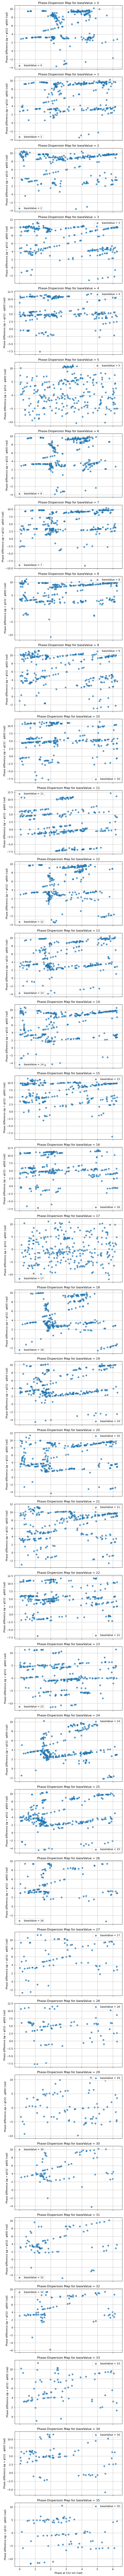

base: 17, fill ratio = 0.460, Δφ_range = 23.03
base: 5, fill ratio = 0.400, Δφ_range = 21.52
base: 21, fill ratio = 0.318, Δφ_range = 14.34
base: 9, fill ratio = 0.295, Δφ_range = 14.06
base: 23, fill ratio = 0.282, Δφ_range = 22.95
base: 11, fill ratio = 0.275, Δφ_range = 19.42
base: 16, fill ratio = 0.273, Δφ_range = 18.97
base: 19, fill ratio = 0.265, Δφ_range = 14.76
base: 13, fill ratio = 0.263, Δφ_range = 14.44
base: 15, fill ratio = 0.260, Δφ_range = 20.14


In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 设置数据库路径和表名
db_path = 'D:/WORK/Achromatic_metalens_design_in_Windows/data/Main.db'   # <-- 替换为你的数据库路径
table_name = 'Parameter'  # <-- 替换为你的表名

# 连接数据库
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 查询所有数据
query = f"""
    SELECT baseValue, angleIn532, angleIn800 FROM {table_name}
    WHERE angleIn532 IS NOT NULL AND angleIn800 IS NOT NULL
"""
cursor.execute(query)
rows = cursor.fetchall()
conn.close()

# 分类数据：每个 baseValue 一个组
grouped_data = defaultdict(list)

for baseValue, phi_532, phi_800 in rows:
    delta_phi = phi_532 - phi_800  # 色散（正方向）
    grouped_data[baseValue].append((phi_532, delta_phi))

# 绘图
n_groups = len(grouped_data)
fig, axes = plt.subplots(n_groups, 1, figsize=(7, 4 * n_groups), sharex=True)

if n_groups == 1:
    axes = [axes]  # 保证是列表

for ax, (base, points) in zip(axes, grouped_data.items()):
    phi_532_list, delta_phi_list = zip(*points)

    ax.scatter(phi_532_list, delta_phi_list, label=f'baseValue = {base}', alpha=0.7)
    ax.set_ylabel("Phase difference Δφ = φ532 - φ800 (rad)")
    ax.set_title(f"Phase-Dispersion Map for baseValue = {base}")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Phase at 532 nm (rad)")

plt.tight_layout()
plt.show()

def compute_fill_ratio(phi_array, delta_array, bins=20):
    # 计算二维直方图
    H, _, _ = np.histogram2d(phi_array, delta_array, bins=bins)
    filled_cells = np.sum(H > 0)
    fill_ratio = filled_cells / (bins * bins)
    return fill_ratio

# 按 baseValue 分类结构数据 grouped_data = {base: [(phi_532, delta_phi), ...]}
result = []

for base, points in grouped_data.items():
    if len(points) < 5:
        continue  # 样本过少，不具代表性

    phi_array, delta_array = zip(*points)
    phi_array = np.array(phi_array)
    delta_array = np.array(delta_array)

    delta_phi_range = np.max(delta_array) - np.min(delta_array)
    phi_range = np.max(phi_array) - np.min(phi_array)

    fill_ratio = compute_fill_ratio(phi_array, delta_array, bins=20)

    result.append({
        "base": base,
        "Δφ_range": delta_phi_range,
        "φ_range": phi_range,
        "fill_ratio": fill_ratio
    })

# 选出色散范围大 + 分布最均匀的 baseValue
best = sorted(result, key=lambda x: (x["fill_ratio"], x["Δφ_range"]), reverse=True)

# 打印前几个
for item in best[:10]:
    print(f"base: {item['base']}, fill ratio = {item['fill_ratio']:.3f}, Δφ_range = {item['Δφ_range']:.2f}")